In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import warnings
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
zillow = pd.read_csv('zillow-carlifornia.csv',index_col='Date', parse_dates=True, squeeze=True)
zillow.head()

,MedianSoldPrice_AllHomes.California,MedianMortageRate,UnemploymentRate
Date,,,
2008-02-29,470000.0,5.29,6.3
2008-03-31,441000.0,5.44,6.2
2008-04-30,460000.0,5.42,6.4
2008-05-31,429000.0,5.47,6.3
2008-06-30,437500.0,5.60,6.2


In [4]:
zillow = zillow[['MedianSoldPrice_AllHomes.California']]

In [5]:
zillow = zillow.rename(columns={"MedianSoldPrice_AllHomes.California": "sale_price"})

In [6]:
zillow.tail(20)

,sale_price
Date,
2015-05-31,475000.0
2015-06-30,489000.0
2015-07-31,482750.0
2015-08-31,475000.0
2015-09-30,470000.0
2015-10-31,470000.0
2015-11-30,485750.0
2015-12-31,485000.0
2016-01-31,NaN


In [7]:
zillow = zillow.dropna()

In [8]:
zillow.tail()

,sale_price
Date,
2015-08-31,475000.0
2015-09-30,470000.0
2015-10-31,470000.0
2015-11-30,485750.0
2015-12-31,485000.0


In [9]:
len(zillow)

95

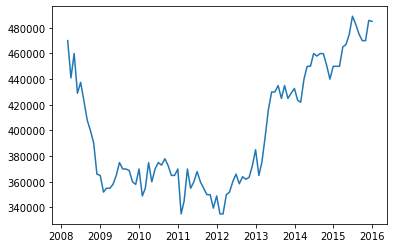

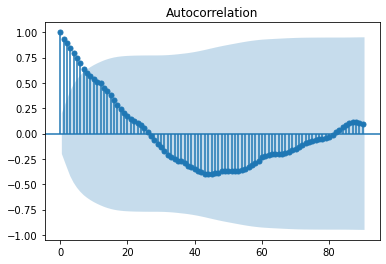

In [10]:
plt.plot(zillow)
plt.show()
plot_acf(zillow,lags = 90)
plt.show()

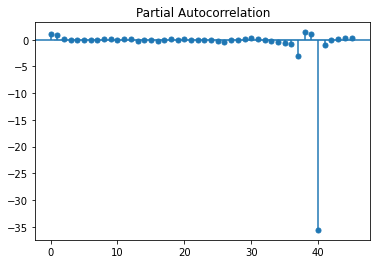

In [11]:
plot_pacf(zillow,lags = 45)
plt.show()

In [12]:
# define all the functions we will need 

# trend and seasonal differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff
#trend differencing: interval=1
#seasonal differencing: interval=m


#grid order search based on BIC
#auto-arima order selection in pmdarima
#python -m pip install pmdarima doesn't work for my python 3.9 anymore, so I wrote one

def bic_sarima(data, p_values,d_values,q_values,P_values,Q_values,m_values, D=1): #added m_values
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                for m in m_values:
                                    order=(p,d,q)
                                    seasonal_order=(P,D,Q,m)
                                    try:
                                        res = sm.tsa.statespace.SARIMAX(data,order=order,seasonal_order=seasonal_order,enforce_stationarity=False,enforce_invertibility=False).fit()
                                        bic=res.bic
                                        if bic < best_score:
                                            best_score, best_order, best_seasonal_order=bic, order,seasonal_order
                                    except:
                                        continue
    print((best_score, best_order, best_seasonal_order))
    
#model evaluation based on RMSE and one-step cross validation
def rmse_sarima(X, trend_order, seasonal_order, split_size): #added split_size
    train_size = int(len(X) * split_size)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=trend_order,seasonal_order=seasonal_order)
        res = model.fit()
        yhat = res.predict(start=len(history), end=len(history)) #predict one step
        predictions.append(yhat) #store prediction
        history.append(test[t]) #store observation
        # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

def evaluate_rmse_sarima(data, p_values,d_values,q_values,P_values,Q_values,m, D=1):
    best_score, best_order, best_seasonal_order = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                    for P in P_values:
                            for Q in Q_values:
                                order=(p,d,q)
                                seasonal_order=(P,D,Q,m)
                                try:
                                    rmse=rmse_sarima(data,trend_order=order, seasonal_order=seasonal_order)
                                    if rmse < best_score:
                                        best_score, best_order, best_seasonal_order=rmse, order,seasonal_order
                                except:
                                    continue
    print((best_score, best_order, best_seasonal_order))

In [12]:
d1 = diff(zillow.values,1)   # differencing once

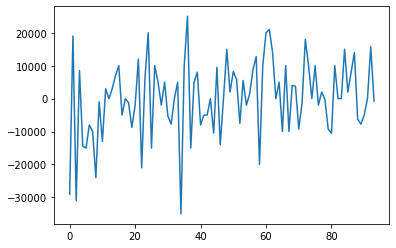

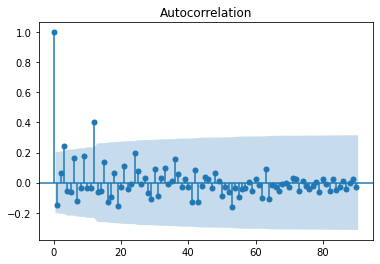

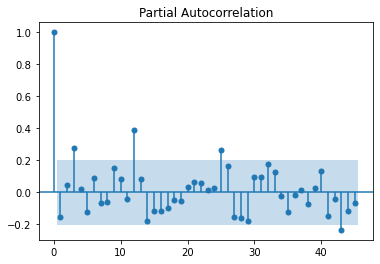

In [13]:
plt.plot(d1)
plot_acf(d1,lags=90) 
plt.show()
plot_pacf(d1,lags=45) 
plt.show()

In [14]:
d2 = diff(d1,1)    # differencing twice

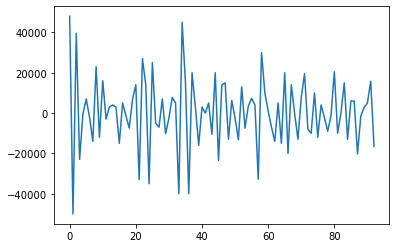

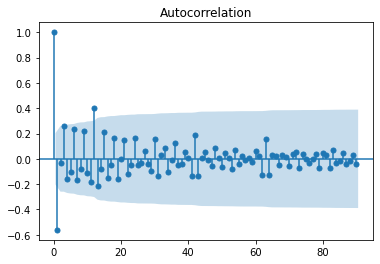

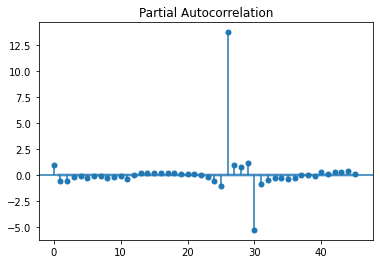

In [15]:
plt.plot(d2)
plot_acf(d2,lags=90) 
plt.show()
plot_pacf(d2,lags=45) 
plt.show()

In [16]:
dftest = adfuller(d1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


In [17]:
dftest = adfuller(d2)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -7.390432e+00
p-value           8.027576e-11
dtype: float64


In [18]:
from statsmodels.tsa.stattools import arma_order_select_ic     
arma_order_select_ic(d2,max_ar=5, max_ma=5, ic='bic')

{'bic':              0            1            2            3            4  \
 0  2087.961822  2016.294028  2016.841843  2019.669593  2021.355711   
 1  2053.268684  2016.484134  2023.931164  2025.907932  2025.332262   
 2  2027.415477  2020.979062  2024.497714  2019.411062  2023.938431   
 3  2029.951875  2033.511142  2024.738814          NaN  2028.441044   
 4  2034.266556  2024.635003  2027.482973          NaN          NaN   
 5  2034.040014  2026.874698          NaN          NaN  2037.100718   
 
              5  
 0  2024.726013  
 1  2029.050466  
 2  2032.341084  
 3  2030.708923  
 4  2035.808438  
 5  2038.633990  ,
 'bic_min_order': (0, 1)}

In [19]:
# model 1 chosen ARIMA(0,2,1)

In [20]:
m_values=[0]
d_values=[1,2,3]
p_values=[0,1,2,3,4]
q_values=[0,1,2,3,4]
Q_values=[0]
P_values=[0]
bic_sarima(zillow, p_values,d_values,q_values,P_values,Q_values,m_values, D=0)

(1909.91098903871, (0, 2, 4), (0, 0, 0, 0))


In [21]:
# model 2 chosen ARIMA(0,2,4)

In [22]:
# choose a model from model 1 and model 2

In [23]:
X=np.array(zillow.values)
rmse1 = rmse_sarima(X, (0,2,1), (0,0,0,0), 0.8)
rmse2 = rmse_sarima(X, (0,2,4), (0,0,0,0), 0.8)

In [24]:
rmse1, rmse2

(10323.72411408035, 10563.062912056892)

In [30]:
# is there seasonality?

In [31]:
dm = diff(d1,3) # one trend and seasonality of 3

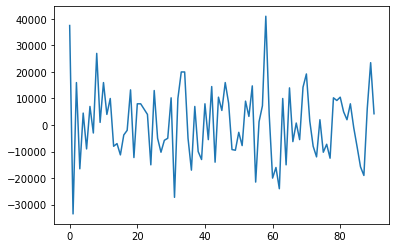

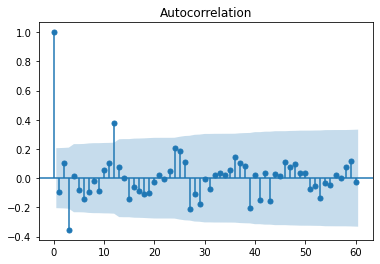

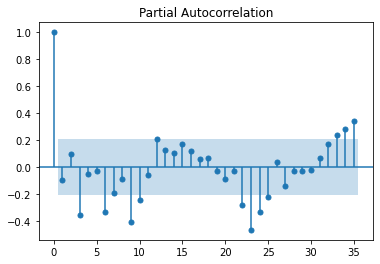

In [32]:
plt.plot(dm)
plot_acf(dm,lags=60) 
plt.show()
plot_pacf(dm,lags=35) 
plt.show()

In [33]:
dftest = adfuller(dm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -7.670597e+00
p-value           1.597505e-11
dtype: float64


In [34]:
dm = diff(d1,6) # one trend and seasonality of 6

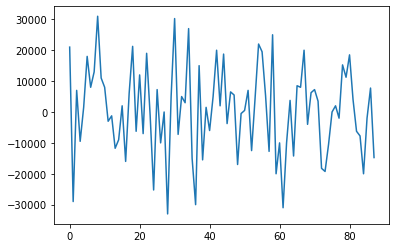

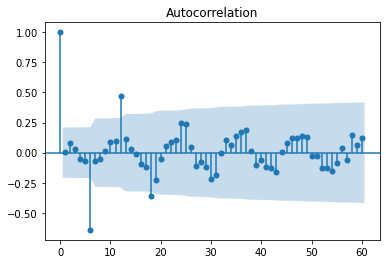

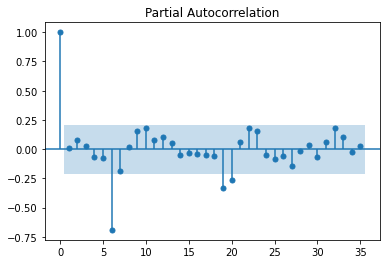

In [35]:
plt.plot(dm)
plot_acf(dm,lags=60) 
plt.show()
plot_pacf(dm,lags=35) 
plt.show()

In [36]:
dftest = adfuller(dm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -8.869026e+00
p-value           1.414472e-14
dtype: float64


In [37]:
dm = diff(d1,12)   # one trend and seasonality of 12

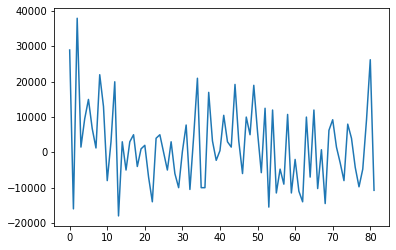

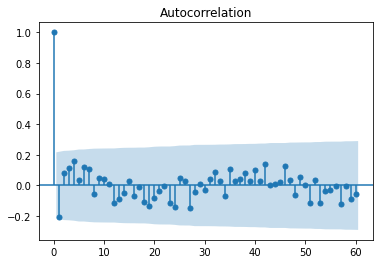

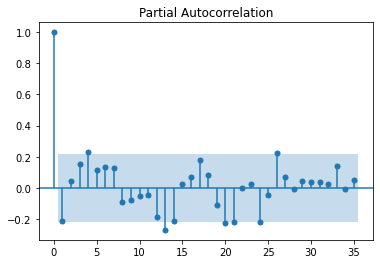

In [38]:
plt.plot(dm)
plot_acf(dm,lags=60) 
plt.show()
plot_pacf(dm,lags=35) 
plt.show()

In [39]:
dftest = adfuller(dm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -1.137508e+01
p-value           8.786119e-21
dtype: float64


In [40]:
dm = diff(d2,3)    # two trend and seasonality of 3

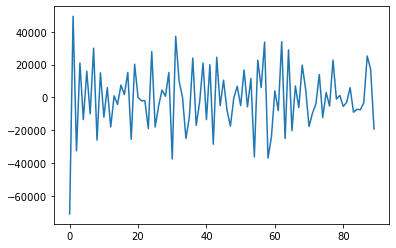

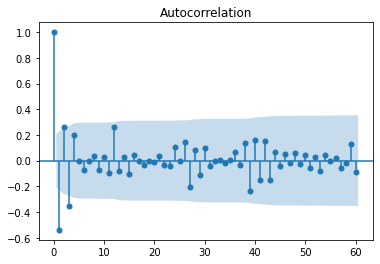

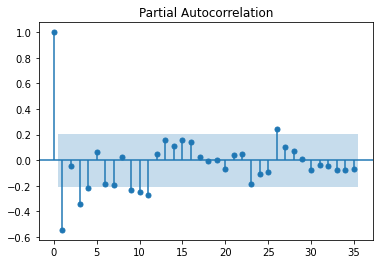

In [41]:
plt.plot(dm)
plot_acf(dm,lags=60) 
plt.show()
plot_pacf(dm,lags=35) 
plt.show()

In [42]:
dftest = adfuller(dm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -7.020498e+00
p-value           6.562382e-10
dtype: float64


In [43]:
dm = diff(d2,6)    # two trend and seasonality of 6

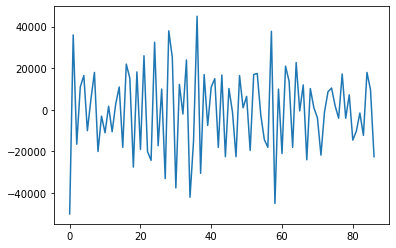

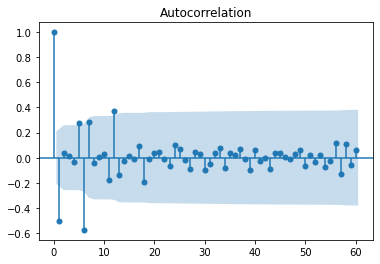

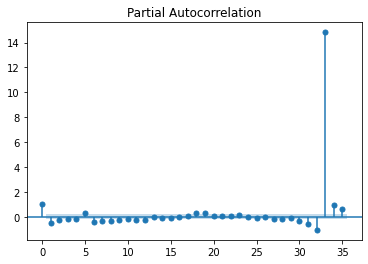

In [44]:
plt.plot(dm)
plot_acf(dm,lags=60) 
plt.show()
plot_pacf(dm,lags=35) 
plt.show()

In [45]:
dftest = adfuller(dm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -7.581578e+00
p-value           2.673200e-11
dtype: float64


In [46]:
dm = diff(d2,12)    # two trend and seasonality of 12

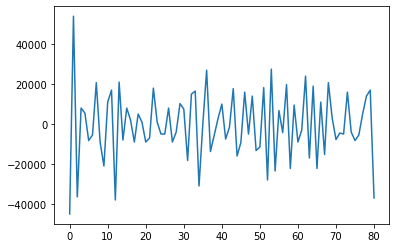

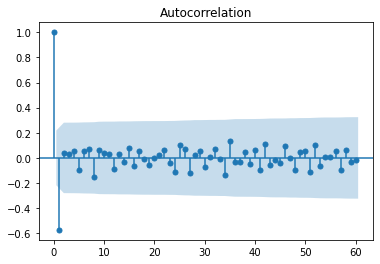

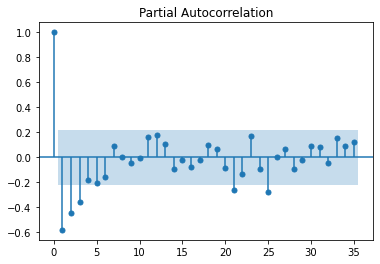

In [47]:
plt.plot(dm)
plot_acf(dm,lags=60) 
plt.show()
plot_pacf(dm,lags=35) 
plt.show()

In [48]:
dftest = adfuller(dm)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -6.469165e+00
p-value           1.380931e-08
dtype: float64


In [49]:
m_values=[3,12]
d_values=[1,2]
p_values=[0,1,2]
q_values=[0,1,2]
Q_values=[0,1,2]
P_values=[0,1,2]
bic_sarima(zillow, p_values,d_values,q_values,P_values,Q_values,m_values, D=1)

(27.92288832594992, (2, 2, 2), (0, 1, 2, 12))


In [13]:
X=np.array(zillow.values)
rmse3 = rmse_sarima(X, (2,2,2), (0,1,2,12), 0.8)      #model 3 = (2, 2, 2), (0, 1, 2, 12)

In [51]:
rmse3

11487.43526426531

In [52]:
m_values=[3,12] 
d_values=[1,2]
p_values=[3,4]
q_values=[3,4]
Q_values=[3,4]
P_values=[3,4]
bic_sarima(zillow, p_values,d_values,q_values,P_values,Q_values,m_values, D=1)

(623.9912405790142, (3, 2, 4), (3, 1, 4, 12))


In [14]:
X=np.array(zillow.values)
rmse4 = rmse_sarima(X, (3,2,4), (3,1,4,12), 0.8)    # model 4 = (3, 2, 4), (3, 1, 4, 12)

In [15]:
rmse4

11542.284366872449

In [16]:
#model 3 performs better